In [10]:
import importlib
import moc_cart_threaded as MOC
# import moc_cart as MOC
import shapely

import matplotlib.pyplot as plt

In [11]:
from plot_scalar_flux import *

In [ ]:
materials = {
    "reflector": MOC.Material(2.0, 1.80, 0.0, "reflector", "blue"),
    "scatterer": MOC.Material(2.0, 1.99, 0.0, "scatterer", "red"),
    "absorber": MOC.Material(10.0, 2.0, 0.0, "absorber", "green"),
    "air": MOC.Material(0.1, 0.006, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "isotropic": MOC.Material(0.1, 0, 1, "isotropic", "purple"),
    "detector": MOC.Material(1.0, 0, 0, "detector", "yellow"),
    "vacuum": MOC.Material(0.0, 0.0, 0.0, "vacuum", "black"),
}

In [13]:
total_dx = 5
def make_blocks(x0, y0, dx=0.1, total_dx=total_dx, material=materials["reflector"]):
    """Create a grid of blocks in the x-y plane."""
    
    if type(material) is str:
        material = materials[material]
    
    number_blocks = int(total_dx / dx)
    assert number_blocks == total_dx / dx, "total_dx must be a multiple of dx"
    
    cells = {}
    for i_block in range(number_blocks):
        for j_block in range(number_blocks):
            x = x0 + i_block * dx
            y = y0 + j_block * dx
            cell = shapely.geometry.box(x, y, x+dx, y+dx)
            cell_data = MOC.CellData(cell, material)
            cells[cell] = cell_data
            
    return cells

def plot_mesh(cells):
    # fig, ax = plt.subplots()
    # for cell, cell_data in cells.items():
    #     shapely.plotting.plot_polygon(
    #         cell, color=cell_data.material.color, alpha=0.5, ax=ax
    #     )

    fig, ax = plt.subplots()
    material_handles = {}
    for cell, cell_data in cells.items():
        coords = np.array(cell.exterior.coords)
        polygon = plt.Polygon(
            coords,
            closed=True,
            facecolor=cell_data.material.color,
            alpha=0.5,
            edgecolor="black",
            linewidth=0.03,
        )
        ax.add_patch(polygon)

        mat_name = cell_data.material.name
        if mat_name not in material_handles:
            material_handles[mat_name] = mpatches.Patch(
                facecolor=cell_data.material.color,
                edgecolor="black",
                alpha=0.5,
                label=mat_name
                )

    ax.autoscale_view()
    ax.set_aspect("equal")

    ax.legend(
        handles=list(material_handles.values()),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    return fig, ax

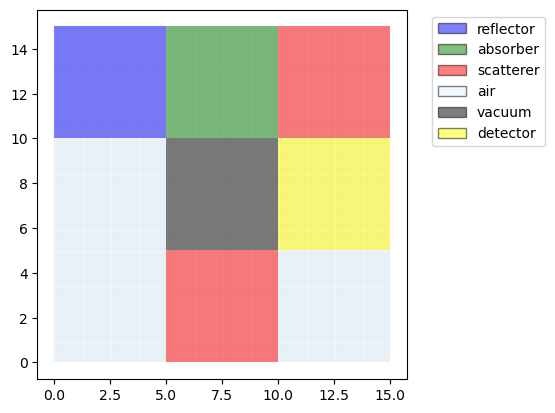

In [14]:
cells_nw = make_blocks(0, 2*total_dx, material="reflector")
cells_n = make_blocks(total_dx, 2*total_dx, material="absorber")
cells_ne = make_blocks(2*total_dx, 2*total_dx, material="scatterer")

# cells_w = make_blocks(0, 5, material="air")
cells_w = make_blocks(0, total_dx, material="air")
# cells_c = make_blocks(total_dx, total_dx, material="isotropic")
cells_c = make_blocks(total_dx, total_dx, material="vacuum")
cells_e = make_blocks(2*total_dx, total_dx, material="detector")

cells_sw = make_blocks(0, 0, material="air")
cells_s = make_blocks(total_dx, 0, material="scatterer")
cells_se = make_blocks(2*total_dx, 0, material="air")

cells = {
    **cells_nw, **cells_n, **cells_ne,
    **cells_w, **cells_c, **cells_e, **cells_sw, **cells_s, **cells_se
}
fig, ax = plot_mesh(cells)

In [19]:
importlib.reload(MOC)

quadrature = MOC.ProductQuadrature(4, 2)
incident_flux = 10

solver = MOC.CartesianMOC(
    cells,
    quadrature,
    bc_east=incident_flux,
    bc_west=incident_flux,
    bc_north=incident_flux,
    bc_south=incident_flux,
    ray_width=0.05,
)

In [20]:
solver.solve(tolerance=1e-6)

Generating rays...
Rays generated in 14.45 seconds
Iter 0 error: 174.017365
Iter 1 error: 13.048956
Iter 2 error: 4.216182
Iter 3 error: 1.591895
Iter 4 error: 0.641936
Iter 5 error: 0.269412
Iter 6 error: 0.116207
Iter 7 error: 0.051143
Iter 8 error: 0.022859
Iter 9 error: 0.010343
Iter 10 error: 0.004727
Iter 11 error: 0.002178
Iter 12 error: 0.001010
Iter 13 error: 0.000472
Iter 14 error: 0.000221
Iter 15 error: 0.000104
Iter 16 error: 0.000049
Iter 17 error: 0.000023
Iter 18 error: 0.000011
Iter 19 error: 0.000005
Iter 20 error: 0.000003
Iter 21 error: 0.000001
Iter 22 error: 0.000001
Converged in 22 iterations with error 0.000001


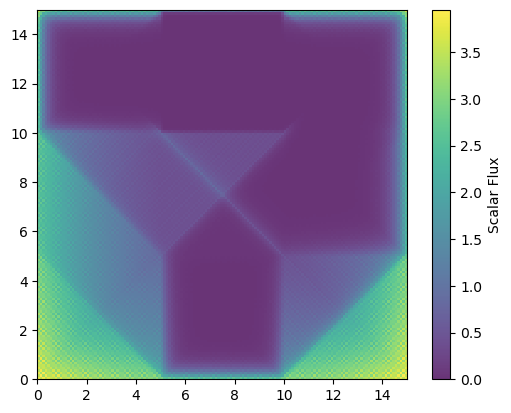

In [21]:
fig = plot_scalar_flux(solver)

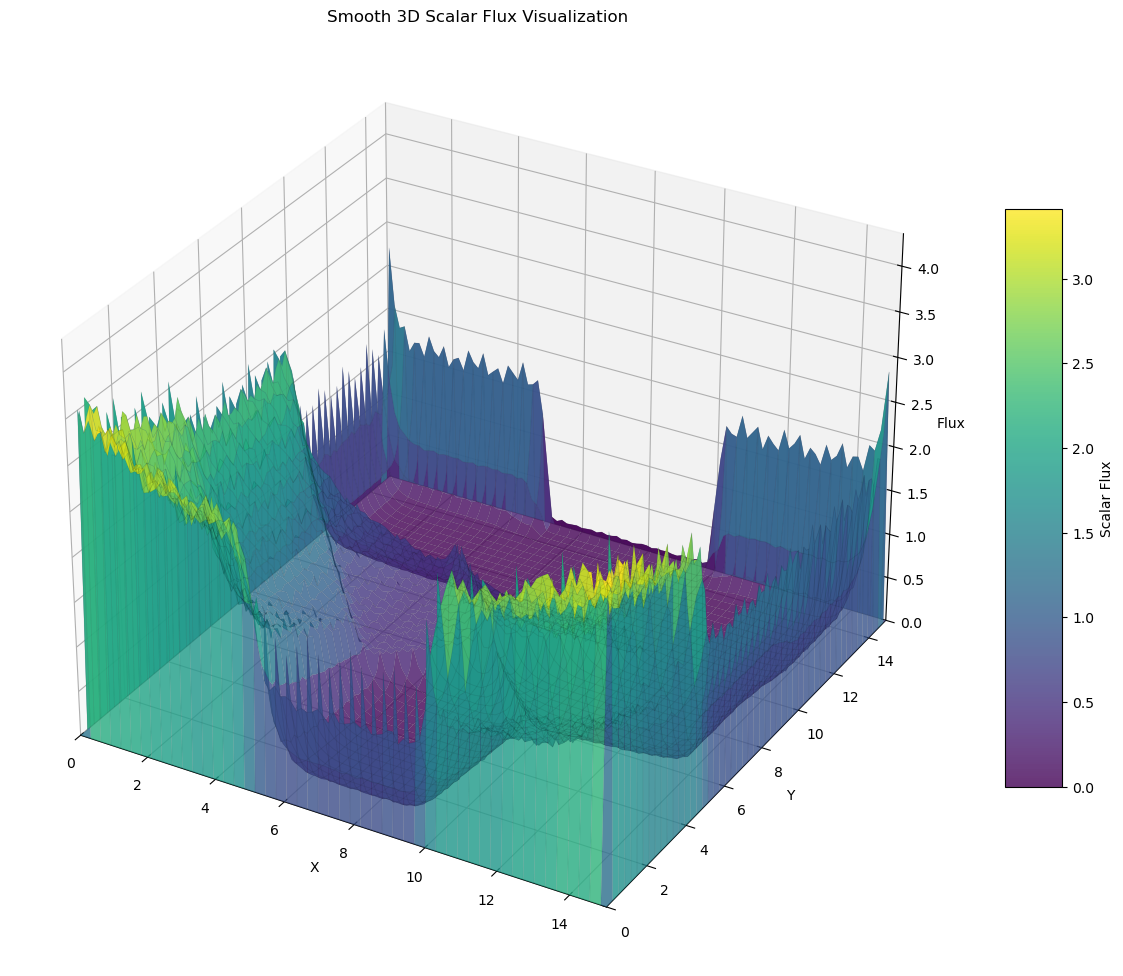

In [22]:
fig = plot_scalar_flux_3D(solver)